<a href="https://colab.research.google.com/github/DYNAFEM/REGRESION-PESO-BOVINOS/blob/MODELOS-MLP-REGRESOR/SHP_V0_CROSS_VALID_MLP_REGRESION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importar Librerias Necesarias

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Montar Datos y Separar Predictora

In [ ]:
# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Cargar datos procesados
ruta_train = '/content/drive/My Drive/REGRESION_PESO/DATOS_TRAIN_TEST_STANDARD/train_dataset.csv'
ruta_test = '/content/drive/My Drive/REGRESION_PESO/DATOS_TRAIN_TEST_STANDARD/test_dataset.csv'

train_df = pd.read_csv(ruta_train)
test_df = pd.read_csv(ruta_test)

# Separar datos
X_train = train_df.drop(columns=['weight_in_kg'])
y_train = train_df['weight_in_kg']

X_test = test_df.drop(columns=['weight_in_kg'])
y_test = test_df['weight_in_kg']

In [ ]:
print(X_train.head())
print(X_train.shape)


   age_in_year     teeth  height_in_inch     price  sex_MALE_BULL  color_RED  \
0     1.643310  1.653526       -0.948784 -0.242195       0.121867   0.829001   
1    -0.551338 -0.547596        0.523196  0.014779       0.121867   0.829001   
2    -0.551338 -0.547596       -0.059463 -0.587513       0.121867   0.829001   
3    -0.551338 -0.547596       -1.102116 -0.270972       0.121867   0.829001   
4    -0.551338 -0.547596       -1.102116 -0.645066       0.121867   0.829001   

   breed_HOSTINE_CROSS  breed_LOCAL  breed_MIR_KADIM  breed_PABNA_BREED  \
0            -0.260208     0.677551        -0.070014          -0.099258   
1            -0.260208     0.677551        -0.070014          -0.099258   
2            -0.260208     0.677551        -0.070014          -0.099258   
3            -0.260208     0.677551        -0.070014          -0.099258   
4            -0.260208     0.677551        -0.070014          -0.099258   

   breed_RED_CHITTAGONG  breed_SAHIWAL  breed_SINDHI  size_LARGE  si

# MODELO BASES

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modelo base MLP
mlp_base = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # arquitectura base
    activation='relu',             # función de activación estándar
    solver='adam',                 # optimizador
    learning_rate_init=0.001,      # LR inicial
    max_iter=500,                  # iteraciones suficientes
    random_state=42
)

# Entrenamiento
mlp_base.fit(X_train, y_train.ravel())

# Predicciones
y_train_pred = mlp_base.predict(X_train)
y_test_pred  = mlp_base.predict(X_test)

# Métricas
train_mae  = mean_absolute_error(y_train, y_train_pred)
train_mse  = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2   = r2_score(y_train, y_train_pred)

test_mae  = mean_absolute_error(y_test, y_test_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test, y_test_pred)

# Resultados
print("\n📌 Resultados del MLP Base")
print("=== Train ===")
print(f"MAE:  {train_mae:.4f}")
print(f"MSE:  {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"R²:   {train_r2:.4f}")

print("\n=== Test ===")
print(f"MAE:  {test_mae:.4f}")
print(f"MSE:  {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²:   {test_r2:.4f}")


/tmp/ipython-input-1404706959.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  mlp_base.fit(X_train, y_train.ravel())



📌 Resultados del MLP Base
=== Train ===
MAE:  15.3101
MSE:  504.0172
RMSE: 22.4503
R²:   0.9159

=== Test ===
MAE:  20.0314
MSE:  951.0960
RMSE: 30.8398
R²:   0.7315


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# 1) Definir el modelo como función de hp
def build_model(hp, input_dim):
    model = Sequential()
    model.add(Dense(
        units=hp.Int("units_1", min_value=64, max_value=256, step=32),
        activation="relu",
        input_shape=(input_dim,)
    ))
    model.add(Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int("units_2", min_value=16, max_value=128, step=16),
        activation="relu"
    ))
    model.add(Dense(1))

    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

In [ ]:
# 2) Tuner con VALIDACIÓN CRUZADA (K-Fold)
#    Subclasificando RandomSearch para hacer CV
class CVRandomSearch(kt.tuners.RandomSearch):
    def __init__(self, X, y, kf, epochs=100, patience=10, verbose=0, **kwargs):
        super().__init__(**kwargs)
        self.X = X
        self.y = y
        self.kf = kf
        self.epochs = epochs
        self.patience = patience
        self.verbose = verbose

    def run_trial(self, trial, *args, **kwargs):
        # Hyperparams para este trial
        hp = trial.hyperparameters

        # Batch size como hp (se usa en cada fit)
        batch_size = hp.Choice("batch_size", values=[16, 32, 64])

        fold_maes, fold_losses = [], []

        # K-Fold CV
        for train_idx, val_idx in self.kf.split(self.X):
            X_tr, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_tr, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            model = build_model(hp, input_dim=X_tr.shape[1])
            early_stop = EarlyStopping(
                monitor="val_loss", patience=self.patience, restore_best_weights=True
            )

            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_val, y_val),
                epochs=self.epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=self.verbose
            )

            # Evaluar en el fold
            loss, mae = model.evaluate(X_val, y_val, verbose=0)
            fold_losses.append(loss)
            fold_maes.append(mae)

        # Promedios de CV para objetivo del tuner
        mean_loss = float(np.mean(fold_losses))
        mean_mae  = float(np.mean(fold_maes))

        # Reportar métricas al Oracle (usamos val_mae como objetivo)
        self.oracle.update_trial(
            trial.trial_id,
            metrics={"val_loss": mean_loss, "val_mae": mean_mae}
        )
        # self.save_model(trial.trial_id, model)  # opcional

In [ ]:
# 3) Ejecutar RandomSearch con CV

N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

tuner = CVRandomSearch(
    X=X_train,
    y=y_train,
    kf=kf,
    epochs=100,
    patience=10,
    verbose=0,
    hypermodel=lambda hp: build_model(hp, input_dim=X_train.shape[1]),
    objective=kt.Objective("val_mae", direction="min"),
    max_trials=20,                 # <-- ajusta cuántas combinaciones aleatorias probar
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="regresion_peso_randomcv"
)

tuner.search()  # ¡lanza la búsqueda!

best_hp = tuner.get_best_hyperparameters(1)[0]
print("\n=== Mejores hiperparámetros (RandomSearch + CV) ===")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

Trial 20 Complete [00h 01m 28s]
val_mae: 23.41832389831543

Best val_mae So Far: 14.337293815612792
Total elapsed time: 00h 22m 47s

=== Mejores hiperparámetros (RandomSearch + CV) ===
units_1: 192
dropout: 0.4
units_2: 16
lr: 0.0022342365914000857
batch_size: 16


In [ ]:
# 4) Entrenamiento cruzado final con hp óptimos
#    y métricas por fold: MAE, MSE, RMSE, R²

EPOCHS_FINAL = 100
PATIENCE_FINAL = 10
VERBOSE_FINAL = 0

def build_model_from_hp(hp, input_dim):
    # Helper para reconstruir desde best_hp
    model = Sequential([
        Dense(hp.get("units_1"), activation="relu", input_shape=(input_dim,)),
        Dropout(hp.get("dropout")),
        Dense(hp.get("units_2"), activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=hp.get("lr")), loss="mse", metrics=["mae"])
    return model

metrics_per_fold = []

print("\n=== ENTRENAMIENTO FINAL (K-Fold) CON MEJORES HP ===")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = build_model_from_hp(best_hp, input_dim=X_tr.shape[1])
    early_stop = EarlyStopping(monitor="val_loss", patience=PATIENCE_FINAL, restore_best_weights=True)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS_FINAL,
        batch_size=best_hp.get("batch_size"),
        callbacks=[early_stop],
        verbose=VERBOSE_FINAL
    )

    y_val_pred = model.predict(X_val, verbose=0).reshape(-1)

    mae  = mean_absolute_error(y_val, y_val_pred)
    mse  = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_val, y_val_pred)

    metrics_per_fold.append({
        "fold": fold,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

    print(f"Fold {fold} -> MAE: {mae:.5f} | MSE: {mse:.5f} | RMSE: {rmse:.5f} | R²: {r2:.5f}")

metrics_df = pd.DataFrame(metrics_per_fold)
metrics_mean = metrics_df[["MAE","MSE","RMSE","R2"]].mean().to_dict()

print("\n=== RESUMEN MÉTRICAS POR FOLD (VAL) ===")
print(metrics_df)
print("\n=== PROMEDIO MÉTRICAS (VAL) ===")
for k, v in metrics_mean.items():
    print(f"{k}: {v:.6f}")



=== ENTRENAMIENTO FINAL (K-Fold) CON MEJORES HP ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 -> MAE: 9.05661 | MSE: 147.42740 | RMSE: 12.14197 | R²: 0.95005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 -> MAE: 14.04986 | MSE: 634.41888 | RMSE: 25.18767 | R²: 0.90920


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 -> MAE: 11.77984 | MSE: 689.97528 | RMSE: 26.26738 | R²: 0.86658
Fold 4 -> MAE: 23.43829 | MSE: 1352.53491 | RMSE: 36.77683 | R²: 0.79814


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 -> MAE: 14.18395 | MSE: 539.13446 | RMSE: 23.21927 | R²: 0.93050

=== RESUMEN MÉTRICAS POR FOLD (VAL) ===
   fold        MAE          MSE       RMSE        R2
0     1   9.056605   147.427399  12.141968  0.950050
1     2  14.049863   634.418884  25.187673  0.909198
2     3  11.779839   689.975281  26.267381  0.866581
3     4  23.438288  1352.534912  36.776826  0.798139
4     5  14.183954   539.134460  23.219269  0.930499

=== PROMEDIO MÉTRICAS (VAL) ===
MAE: 14.501710
MSE: 672.698187
RMSE: 24.718623
R2: 0.890893


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


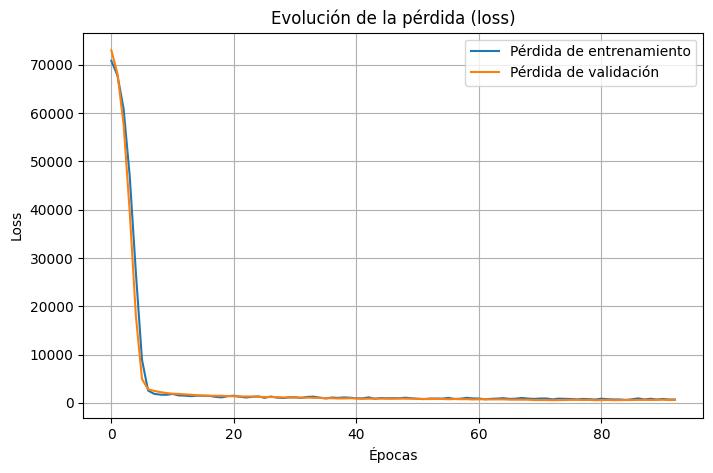


=== MÉTRICAS EN TEST ===
MAE:  14.584980
MSE:  612.911987
RMSE: 24.757059
R²:   0.826946


In [ ]:
import matplotlib.pyplot as plt

# 5) Reentrenar en TODO el train y evaluar en TEST

final_model = build_model_from_hp(best_hp, input_dim=X_train.shape[1])
early_stop_full = EarlyStopping(monitor="val_loss", patience=PATIENCE_FINAL, restore_best_weights=True)

_ = final_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS_FINAL,
    batch_size=best_hp.get("batch_size"),
    callbacks=[early_stop_full],
    verbose=VERBOSE_FINAL
)

# --- Gráfica de pérdidas ---
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Pérdida de entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de validación")
plt.title("Evolución de la pérdida (loss)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

y_test_pred = final_model.predict(X_test, verbose=0).reshape(-1)

test_mae  = mean_absolute_error(y_test, y_test_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test, y_test_pred)

print("\n=== MÉTRICAS EN TEST ===")
print(f"MAE:  {test_mae:.6f}")
print(f"MSE:  {test_mse:.6f}")
print(f"RMSE: {test_rmse:.6f}")
print(f"R²:   {test_r2:.6f}")

In [ ]:
%pip install keras-tuner -q

In [ ]:
print("=== Mejor configuración encontrada ===")

print("hidden_layer_sizes = (",
      best_hp.get('units_1'), ",",
      best_hp.get('units_2'), ")")

print("dropout =", best_hp.get('dropout'))
print("learning_rate =", best_hp.get('lr'))
print("batch_size =", best_hp.get('batch_size'))

=== Mejor configuración encontrada ===
hidden_layer_sizes = ( 192 , 16 )
dropout = 0.4
learning_rate = 0.0022342365914000857
batch_size = 16
